In [22]:
from numpy import genfromtxt
import tensorflow as tf
import tensorflow.keras as keras
'''#from keras.models import Sequential
from keras.layers import Dense, Input, Lambda, Dropout
from keras import regularizers
#from keras.layers import Dropout
from keras.constraints import maxnorm
#from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras import regularizers
#from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras import objectives
from keras.models import model_from_json
from keras.layers import Input, Dense, Convolution1D, MaxPooling1D, UpSampling1D, AveragePooling1D, Flatten ,Reshape,ZeroPadding1D,Cropping1D
from keras.models import Model
#from keras.callbacks import TensorBoard
from keras.regularizers import l2, l1
from keras import optimizers
from keras.layers.noise import GaussianNoise
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras.layers import Dense,concatenate, Input,TimeDistributed,LSTM, Lambda, Dropout, Reshape, Conv1D, Flatten, UpSampling1D, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras import backend as K'''

import tensorflow.keras.backend as K

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, LSTM, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf


from PIL import Image

import os
import sys
import itertools
#import keras_internal_model
import pandas as pd
import numpy as np
#import train_tools as tt
from numpy import genfromtxt
from time import time

import csv

tf.compat.v1.enable_v2_behavior()


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
  except RuntimeError as e:
    print(e)
    
    
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_logical_devices('GPU')

import cv2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

GPUs:  1


In [7]:
def load_images(parent_path,imgs_paths):
    imgs = []
    for i in imgs_paths:
        imgs.append( cv2.imread( os.path.join(parent_path,i)) )
    return np.array(imgs)

In [5]:
img_path = '/home/pico/uni/romi/rl_sony/best_next_move_3d_reconstruction/data/imgs'
idx_file = '/home/pico/uni/romi/rl_sony/best_next_move_3d_reconstruction/data/samples_idx.csv'

df = pd.read_csv(idx_file,usecols=(0,5,6))

In [14]:
imgs = load_images(img_path,df['img'])

In [17]:
print(imgs.shape)
df.head()

(25000, 82, 82, 3)


,img,dp2,dt2
0,009_2d/657_116_281.png,-1,-20
1,001_2d/600_580_044.png,0,-20
2,006_2d/146_686_681.png,-3,-20
3,003_2d/511_158_511.png,-2,-13
4,001_2d/521_535_546.png,-3,20


In [32]:
y = df[['dp2','dt2']].values

In [35]:
th = 17500
x_train = imgs[:th]
y_train = y[:th]
x_test = imgs[th:]
y_test = y[th:]

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

In [27]:
def conv_layer(d, k):
    """ Returns a 2D Conv layer, with and ReLU activation
    """
    # return Conv2D(d, k, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    return Conv2D(d, k, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
def conv_block(inp, d=3, pool_size=(2, 2), k=3):
    """ Returns a 2D Conv block, with a convolutional layer, max-pooling
    """
    conv = conv_layer(d, k)(inp)
    return MaxPooling2D(pool_size=pool_size)(conv)

def network():
    inp = Input((82,82,3))
    x = conv_block(inp, 32, (2, 2), 8)
    x = conv_block(x, 64, (2, 2), 4)
    x = conv_block(x, 64, (2, 2), 3)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(2, activation='linear')(x)
    return Model(inp, x)

In [53]:
model = network()

In [54]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, 
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.MeanSquaredError()])

In [55]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./generated_data/logs",
                                                        histogram_freq=1,
                                                        write_images=True)

In [ ]:
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[tensorboard_callback]
)

Epoch 1/100
274/274 [==============================] - 10s 34ms/step - loss: 735.9317 - mean_squared_error: 735.9317 - val_loss: 172.6946 - val_mean_squared_error: 172.6946
Epoch 2/100
274/274 [==============================] - 9s 33ms/step - loss: 171.7066 - mean_squared_error: 171.7066 - val_loss: 172.6919 - val_mean_squared_error: 172.6919
Epoch 3/100
274/274 [==============================] - 9s 33ms/step - loss: 172.3628 - mean_squared_error: 172.3628 - val_loss: 172.6963 - val_mean_squared_error: 172.6963
Epoch 4/100
274/274 [==============================] - 9s 33ms/step - loss: 172.5219 - mean_squared_error: 172.5219 - val_loss: 172.7090 - val_mean_squared_error: 172.7090
Epoch 5/100
274/274 [==============================] - 9s 34ms/step - loss: 172.6708 - mean_squared_error: 172.6708 - val_loss: 172.7167 - val_mean_squared_error: 172.7167
Epoch 6/100
274/274 [==============================] - 9s 34ms/step - loss: 171.9783 - mean_squared_error: 171.9783 - val_loss: 172.7151 - 

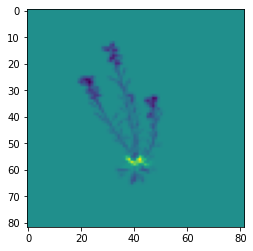

In [52]:
#plt.imshow(x_train[0,:,:,2])

array([[0.2784314, 0.2784314, 0.2784314, ..., 0.2784314, 0.2784314,
        0.2784314],
       [0.2784314, 0.2784314, 0.2784314, ..., 0.2784314, 0.2784314,
        0.2784314],
       [0.2784314, 0.2784314, 0.2784314, ..., 0.2784314, 0.2784314,
        0.2784314],
       ...,
       [0.2784314, 0.2784314, 0.2784314, ..., 0.2784314, 0.2784314,
        0.2784314],
       [0.2784314, 0.2784314, 0.2784314, ..., 0.2784314, 0.2784314,
        0.2784314],
       [0.2784314, 0.2784314, 0.2784314, ..., 0.2784314, 0.2784314,
        0.2784314]], dtype=float32)

In [ ]:
x_train.shape